In [1]:
# nbi:hide_in
# nbi:hide_out
import nbinteract as nbi

# - Manipulação de arquivos
import pandas as pd
import numpy as np
import math
#import pymc3 as pm

In [2]:
# nbi:hide_in
# nbi:hide_out

# - Visualização
import seaborn as sns
import squarify 

# -- Matplotlib -- 
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
# Observar datas em separado
import matplotlib.dates as dates
# Posso utilizar matplotlib inline ou notebook
%matplotlib inline

In [3]:
# nbi:hide_in
# nbi:hide_out

from lifetimes.utils import calibration_and_holdout_data
from lifetimes.utils import summary_data_from_transaction_data
from lifetimes import BetaGeoFitter
from lifetimes import ModifiedBetaGeoFitter

# - Plot
from lifetimes.plotting import plot_history_alive
from lifetimes.plotting import plot_period_transactions
from lifetimes.plotting import plot_frequency_recency_matrix
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases

In [4]:
# nbi:hide_in
# nbi:hide_out

# - Widgets
import ipywidgets as widgets
from IPython.display import display, HTML
from IPython.display import clear_output
from ipywidgets import interact, interact_manual

In [5]:
# nbi:hide_in
# nbi:hide_out
# - Modifica formato de todos os gráficos
sns.set(rc={'figure.figsize': (11.7, 8.27)})

In [6]:
# nbi:hide_in
# nbi:hide_out
# - Arquivo com dados básicos de RFM, a recência aqui utilizada difere da recência aplicada no modelo BDNGB
df_rfmch = pd.read_csv('preprocessed/UserRFMCH.csv')

In [9]:
# nbi:hide_in
# nbi:hide_out
# - Arquivo com informação geral sobre cada compra
df_fato_compras = pd.read_csv('raw/fato_compras.csv')

C:\Users\rodrigo.sarmento\AppData\Local\Continuum\anaconda2\envs\Python\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [23]:
# nbi:hide_in
# nbi:hide_out

# - Organiza Dados
df = df_fato_compras[['data_local','associado_id']]

# - Remove hora da data_compra
df['data_compra']= pd.to_datetime(df['data_local'])
df['data_compra'] = df['data_compra'].dt.date
df.drop(['data_local'],axis=1,inplace=True)

In [24]:
# nbi:hide_in
df.head(1)

,associado_id,data_compra
0,10358,2019-04-25


# Modelo Lifetimes

**Notação matemática que representa as features para um usuário X:**
- **Frequency** : Quantidade de compras no período
- **Recency**: É o período entre sua primeira compra e sua última compra 
- **T**: É o período total do usuário

In [25]:
# nbi:hide_in
# nbi:hide_out
# - Observa a última data de compra
df.data_compra.max()

datetime.date(2019, 7, 4)

In [26]:
# nbi:hide_in
# nbi:hide_out
summary_cal_holdout = calibration_and_holdout_data(df, 
                                                   customer_id_col = 'associado_id', 
                                                   datetime_col = 'data_compra', 
                                                   freq = 'D', #days
                                        calibration_period_end='2019-6-4',
                                        observation_period_end='2019-7-4')

**Dados Transformados**
- Os dados apresentam um "holdout" de 30 dias. Esse holdout serve para a validação do modelo com as previsões que serão apresentadas

In [28]:
# nbi:hide_in
summary_cal_holdout.head(5)

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
associado_id,,,,,
3,17.0,81.0,82.0,6.0,30
4,6.0,72.0,78.0,3.0,30
19,30.0,125.0,131.0,1.0,30
60,7.0,132.0,132.0,1.0,30
61,0.0,0.0,15.0,0.0,30


## **Treina Modelo**

In [29]:
# nbi:hide_in
# nbi:hide_out
mbgnbd = ModifiedBetaGeoFitter(penalizer_coef=0.01)
mbgnbd.fit(summary_cal_holdout['frequency_cal'], 
        summary_cal_holdout['recency_cal'], 
        summary_cal_holdout['T_cal'],
       verbose=True)

Optimization terminated successfully.
         Current function value: -7.523214
         Iterations: 43
         Function evaluations: 44
         Gradient evaluations: 44


C:\Users\rodrigo.sarmento\AppData\Local\Continuum\anaconda2\envs\Python\lib\site-packages\lifetimes\fitters\__init__.py:82: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(pd.Series(np.diag(self.variance_matrix_.values), index=self.params_.index))


<lifetimes.ModifiedBetaGeoFitter: fitted with 43814 subjects, a: 0.00, alpha: 6.92, b: 0.00, r: 0.48>

##  **Previsão Frequência de Compras Utilizando uma "Validação Cruzada" com Dados Antigos**

In [30]:
# nbi:hide_in
# nbi:hide_out
# - t é o período a ser previsto
t = 30
summary_cal_holdout['predicted_purchases'] = mbgnbd.conditional_expected_number_of_purchases_up_to_time(t, summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])

**Com uma previsão de 30 dias, para cobrir o tempo de holdout temos:**

In [31]:
# nbi:hide_in
summary_cal_holdout.head(5)

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout,predicted_purchases
associado_id,,,,,,
3,17.0,81.0,82.0,6.0,30,5.897511
4,6.0,72.0,78.0,3.0,30,2.289279
19,30.0,125.0,131.0,1.0,30,6.629981
60,7.0,132.0,132.0,1.0,30,1.615357
61,0.0,0.0,15.0,0.0,30,0.657166


### Validando Resultado Frequência

In [32]:
# nbi:hide_in
# nbi:hide_out
summary_cal_holdout['diferenca'] = summary_cal_holdout['predicted_purchases'] - summary_cal_holdout['frequency_holdout']

**A média de diferença entre o que foi previsto e o que ocorreu é de 0.l9**

In [33]:
# nbi:hide_in
summary_cal_holdout.diferenca.describe()

count    43814.000000
mean        -0.197338
std          2.204495
min        -23.568221
25%         -0.832150
50%          0.262290
75%          0.847485
max         16.201204
Name: diferenca, dtype: float64

**Distribuição da diferença entre o previsto e a realidade**

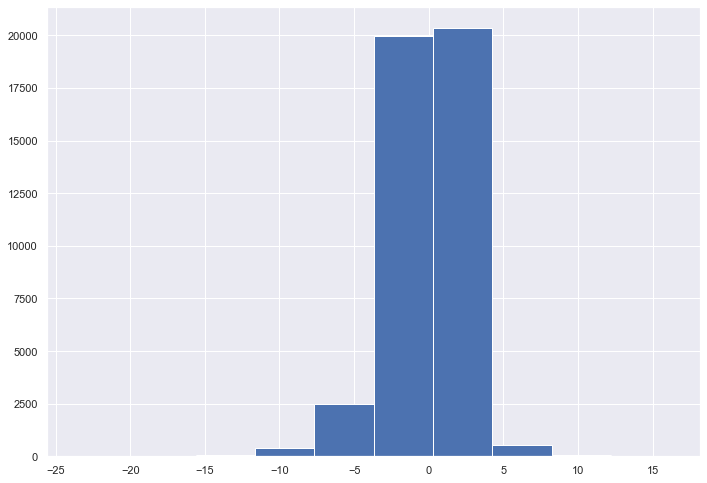

In [34]:
summary_cal_holdout.diferenca.hist()

**Valores que demonstram a diferença**

In [38]:
# nbi:hide_in
frequencia_real = summary_cal_holdout.frequency_holdout.sum()
frequencia_prevista = summary_cal_holdout.predicted_purchases.sum()
freq_dif = frequencia_real - frequencia_prevista

print('Frequência Real no Período de 30 Dias:', frequencia_real, '\nFrequência Prevista no Período:',
      frequencia_prevista, '\nDiferença entre o que aconteceu e o que foi previsto:', freq_dif)

Frequência Real no Período de 30 Dias: 99854.0 
Frequência Prevista no Período: 91207.82094943292 
Diferença entre o que aconteceu e o que foi previsto: 8646.17905056708


**Comparação entre a frequência real (frequência_holdout) e a frequência prevista (model_predictions)**

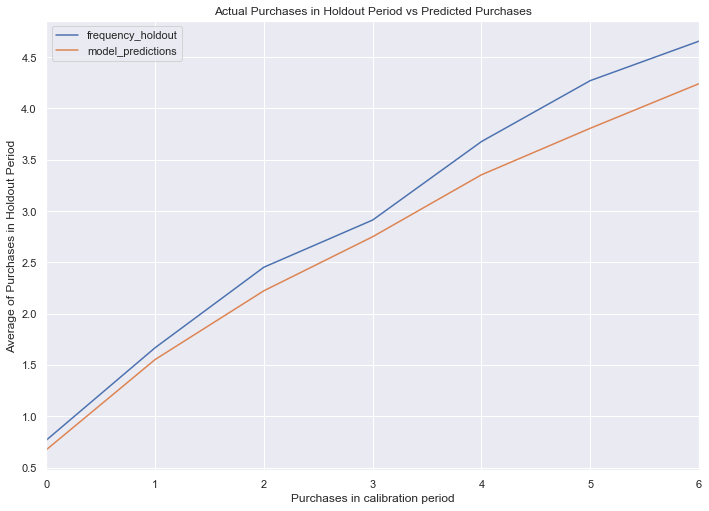

In [39]:
# nbi:hide_in
plot_calibration_purchases_vs_holdout_purchases(mbgnbd, summary_cal_holdout)

**Visualizando a Matriz deFrequency/Recency**
- Quem apresenta um valor alto para recência, diferença grande entre o período de sua primeira compra e sua última(representando que ele continua bem ativo):
    - Apresenta maior chance de realizar compras no futuro

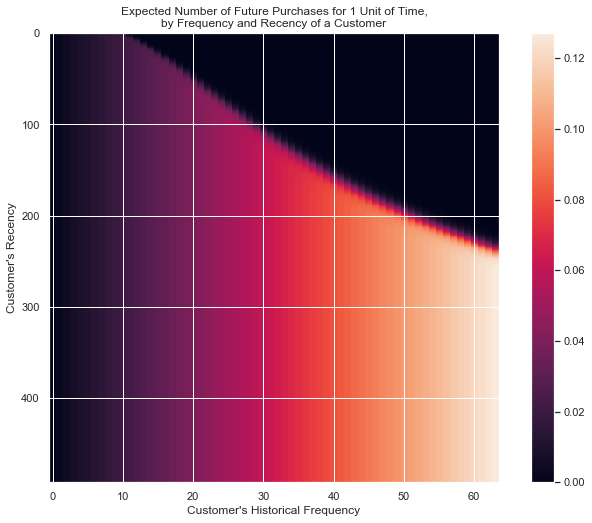

In [40]:
# nbi:hide_in
plot_frequency_recency_matrix(mbgnbd)

**Comparação entre os dados originais e dados artificiais simulados pelos parâmetros encontrados no modelo**

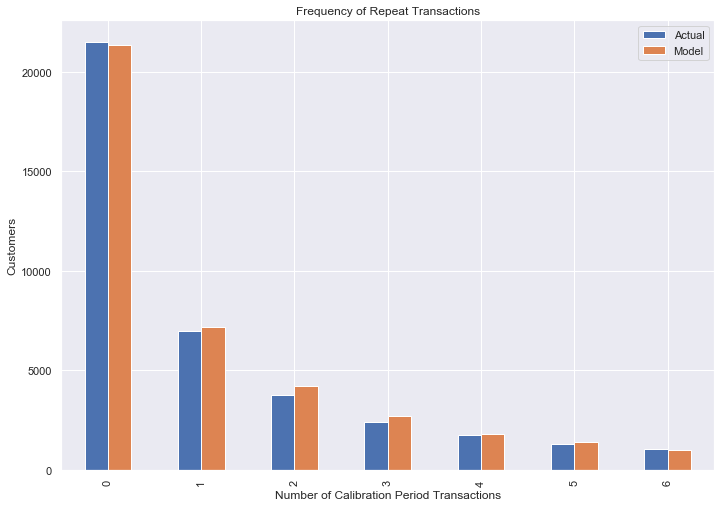

In [41]:
# nbi:hide_in
plot_period_transactions(mbgnbd)

## Previsão de Sobrevivência

In [47]:
# - Transforma os dados para o formato utilizado pelo modelo
summary = summary_data_from_transaction_data(df, 'associado_id', 'data_compra', observation_period_end='2019-7-4')

**Utilizando dados completos**

In [48]:
# nbi:hide_in
summary.head(1)

,frequency,recency,T
associado_id,,,
3,23.0,105.0,112.0


In [49]:
# nbi:hide_in
# nbi:hide_out
mbgnbd = ModifiedBetaGeoFitter(penalizer_coef=0.01)
mbgnbd.fit(summary['frequency'], 
        summary['recency'], 
        summary['T'],
       verbose=True)

Optimization terminated successfully.
         Current function value: -10.396543
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


<lifetimes.ModifiedBetaGeoFitter: fitted with 65844 subjects, a: 0.01, alpha: 8.28, b: 0.20, r: 0.56>

**Comparação com o modelo holdout utilizado anteriormente**

- Optimization terminated successfully.
         Current function value: -9.150911
         Iterations: 40
         Function evaluations: 43
         Gradient evaluations: 43
<lifetimes.ModifiedBetaGeoFitter: fitted with 56716 subjects, a: 0.01, alpha: 7.80, b: 0.14, r: 0.56>

## Previsão de Frequência de Compras

In [50]:
# nbi:hide_in
# nbi:hide_out
# - t é o período a ser previsto
t = 10
summary['predicted_purchases'] = mbgnbd.conditional_expected_number_of_purchases_up_to_time(t, summary['frequency'], summary['recency'], summary['T'])

**Dataframe de Previsões**

In [52]:
# nbi:hide_in
summary.head(5)

,frequency,recency,T,predicted_purchases
associado_id,,,,
3,23.0,105.0,112.0,1.953302
4,9.0,102.0,108.0,0.819833
19,31.0,152.0,161.0,1.859381
60,8.0,142.0,162.0,0.500252
61,0.0,0.0,45.0,0.088961


## Previsão de sobrevivência

In [53]:
# nbi:hide_in
# nbi:hide_out
summary['p_alive'] = mbgnbd.conditional_probability_alive(
    summary['frequency'], summary['recency'], summary['T'])

**Dataframe Contendo Probabilidade de Sobrevivência**

In [54]:
# nbi:hide_in
summary.head(5)

,frequency,recency,T,predicted_purchases,p_alive
associado_id,,,,,
3,23.0,105.0,112.0,1.953302,0.997729
4,9.0,102.0,108.0,0.819833,0.997687
19,31.0,152.0,161.0,1.859381,0.997694
60,8.0,142.0,162.0,0.500252,0.995452
61,0.0,0.0,45.0,0.088961,0.846761


**Descrição da Variável p_alive**

In [56]:
# nbi:hide_in
summary.p_alive.describe()

count    65844.000000
mean         0.927468
std          0.077532
min          0.000003
25%          0.874408
50%          0.950292
75%          0.992891
max          0.999853
Name: p_alive, dtype: float64

**Distribuição da probabilidade de sobrevivência**

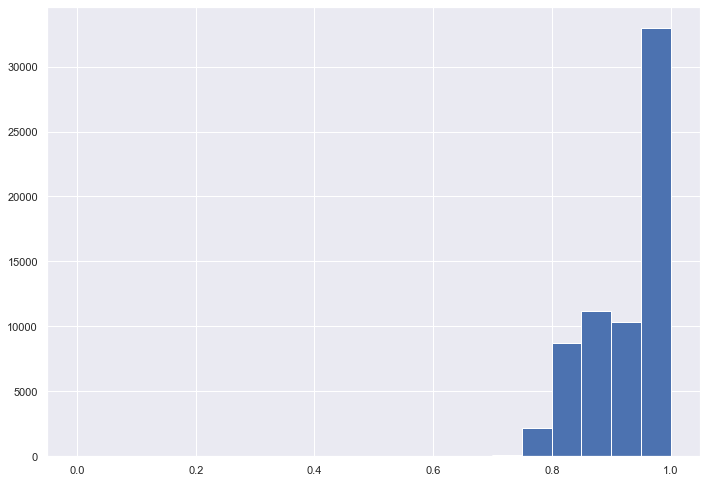

In [57]:
# nbi:hide_in
summary.p_alive.hist(bins=20)

In [59]:
# nbi:hide_in
df_lifetime_rfm = pd.merge(df_rfmch, summary.reset_index(), on='associado_id')

In [60]:
# nbi:hide_in
# nbi:hide_out
def density_plot_var():
    # - Desenha Plot
    plt.figure(figsize=(16, 10), dpi=80)
    try:
        sns.kdeplot(df_lifetime_rfm.loc[df_lifetime_rfm['categoria'] == menu_distri.value,
                           menu_rfm.value], shade=True, color=plt.cm.Spectral(300), label="Distribuição", alpha=.7, shade_lowest=True)
    except:
        sns.kdeplot(df_lifetime_rfm.replace([np.inf, -np.inf], np.nan).dropna().loc[df_lifetime_rfm['categoria'] == menu_distri.value,
                                                                       menu_rfm.value], shade=True, color="dodgerblue", label="Distribuição", alpha=.7)

    # - Decoração
    plt.title('Distribuição '+menu_distri.value, fontsize=22)
    plt.legend()
    plt.show()
    return

def on_button_clicked(_):
    # - Click do botão
    # Função de linkagem
    with out_distri:
        # - Caso o botão seja apertado
        clear_output()
        density_plot_var()


# ---------- Menu Distribuição ----------
# - Menu com as categorias RFM
menu_distri = widgets.Dropdown(
    options=list(df_lifetime_rfm.categoria.unique()),
    value='Vip',
    description='Categoria:')

# - Menu com as variáveis que compõem RFML
menu_rfm = widgets.Dropdown(
    options=['Frequency', 'Recency', 'Monetary', 'Longevity', 'churn','predicted_purchases','p_alive'],
    value='Frequency',
    description='Distribuição:')


button_distri = widgets.Button(description='Gera Distribuição')
out_distri = widgets.Output()

# - Linkando o botão e a função utilizando o método "button's"
button_distri.on_click(on_button_clicked)

# - Cria box que contém os dois. Mostrar o botão e o output juntos
box_distri = widgets.VBox([menu_distri, menu_rfm, button_distri, out_distri])

In [61]:
# nbi:hide_in
box_distri